# Ejercicio aplicado_Predicción de series temporales con LSTM

A continuación vamos a entrenar un modelo de LSTM para predecir el número de pasajeros de avión. Código basado en https://github.com/gianfelton/ 

### Importación de librerías y datos

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('datos\AirPassengers.csv')

In [13]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

### Pre-procesamiento de datos

In [26]:
train, test = df[:-12], df[-12:]

In [29]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [30]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=6)

In [31]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))

In [32]:
model.compile(optimizer='adam', 
              loss='mse')

In [33]:
model.fit_generator(generator,epochs=90)

Epoch 1/90
20/20 [==============================] - 1s 5ms/step - loss: 0.1118
Epoch 2/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 3/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 4/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 5/90
20/20 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 6/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 7/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 8/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 9/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 10/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 11/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 12/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 13/90
20/20 [==============================

<AxesSubplot:>

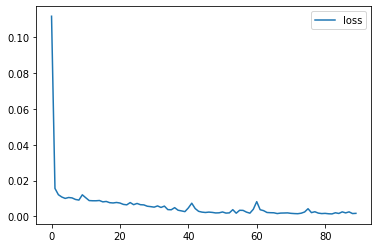

In [34]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### Predicción de 12 meses

A continuación vamos a realizar una predicción para 12 meses (12 predicciones). Para ello vamos a hacer los siguiente:
- crear una lista vacía para cada una de nuestras 12 predicciones
- crear el lote que nuestro modelo predecirá 
- guardar la predicción en nuestra lista
- agregar la predicción al final del lote para usarla en la próxima predicción

In [35]:
pred_list = []

batch = train_scaled[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input): 
    
     # get prediction 1 time stamp ahead 
    pred_list.append(model.predict(batch)[0]) 
    
    # update batch to now include prediction and drop first value
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

#### Invertir la transformación

In [36]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

In [37]:
test

,AirPassengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [38]:
df_test = pd.concat([test,df_predict], axis=1)

No handles with labels found to put in legend.


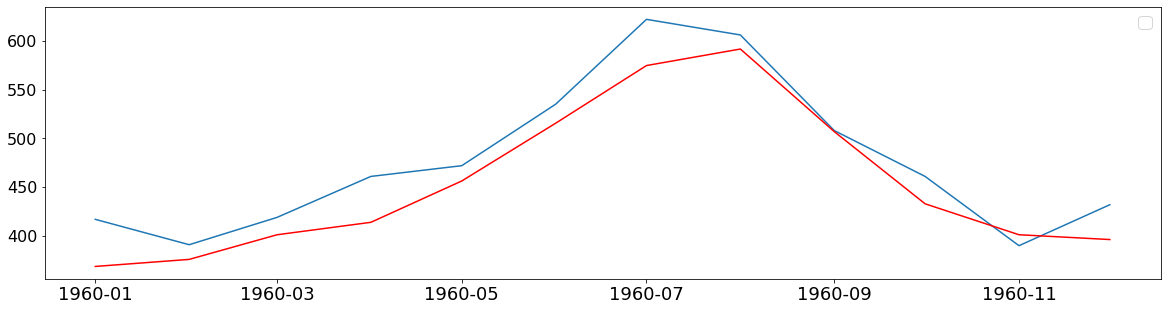

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['AirPassengers'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [40]:
lstm_rmse_error = rmse(df_test['AirPassengers'], df_test["Prediction"])
print("rmse: ", lstm_rmse_error)

rmse:  29.371477794491206
